# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [61]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data study

In [62]:
np.sum(portfolio.isnull())
np.sum(profile.isnull())
np.sum(transcript.isnull())

event     0
person    0
time      0
value     0
dtype: int64

In [63]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [64]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [65]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')

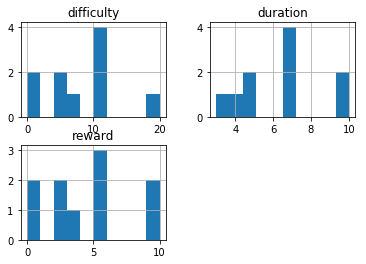

In [66]:
portfolio.hist(column= ['difficulty', 'duration','reward']);

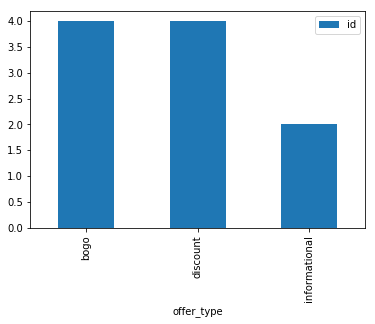

In [67]:
portfolio_offer_type = pd.DataFrame(portfolio.groupby(by=['offer_type'])['id'].count())
portfolio_offer_type.plot.bar();

In [68]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [69]:
profile.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')

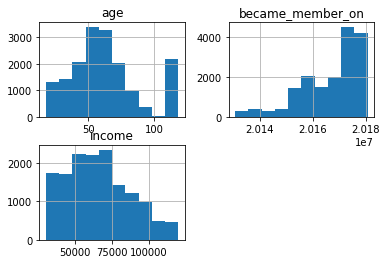

In [70]:
profile.hist(column= ['age', 'became_member_on','income']);

In [71]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

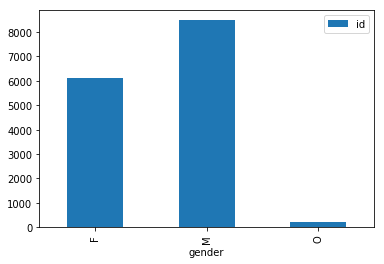

In [72]:
profile_gender = pd.DataFrame(profile.groupby(by=['gender'])['id'].count())
profile_gender.plot.bar();

In [73]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


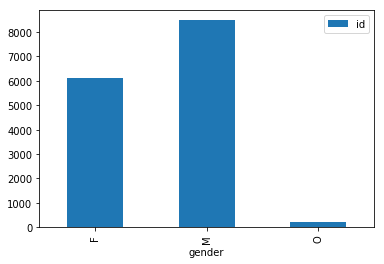

In [74]:
profile_gender = pd.DataFrame(profile.groupby(by=['gender'])['id'].count())
profile_gender.plot.bar();

In [75]:
transcript_no = transcript[transcript['event'] !='transaction' ]

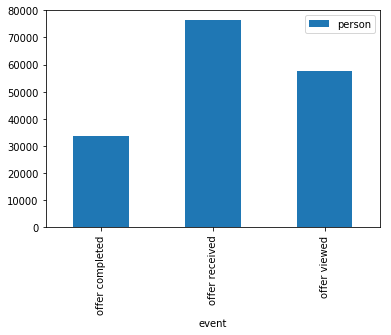

In [76]:
event_type = pd.DataFrame(transcript_no.groupby(by=['event'])['person'].count())
event_type.plot.bar();

In [77]:
trans = transcript[transcript['event'] == 'transaction'].copy()
trans['value'] = trans['value'].apply(lambda x: x['amount'])
trans['lookup'] = list(zip(trans['person'], trans['time']))
trans_look_up_dict = dict(zip(trans['lookup'], trans['value']))
trans.head()

,event,person,time,value,lookup
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,"(02c083884c7d45b39cc68e1314fec56c, 0)"
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,"(9fa9ae8f57894cc9a3b8a9bbe0fc1b2f, 0)"
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,"(54890f68699049c2a04d415abc25e717, 0)"
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,"(b2f1cd155b864803ad8334cdf13c4bd2, 0)"
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,"(fe97aa22dd3e48c8b143116a8403dd52, 0)"


In [78]:
offer_viewed_df = pd.DataFrame(transcript[transcript['event'] == 'offer viewed'])
offer_viewed_df.shape[0]

57725

In [79]:
offer_received_df = pd.DataFrame(transcript[transcript['event'] == 'offer received'])
offer_received_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [80]:
offer_comp_df = pd.DataFrame(transcript[transcript['event'] == 'offer completed'])
offer_comp_df.head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [81]:
offer_received_df.shape[0]/ trans.shape[0]

0.5489410088303239

In [82]:
offer_comp_df.shape[0]/trans.shape[0]

0.24165725101293242

### Distribution study

In [83]:
offer_comp_df['lookup'] = list(zip(offer_comp_df['person'],offer_comp_df['time']))
offer_comp_df['amount'] = offer_comp_df['lookup'].apply(lambda x: trans_look_up_dict[x])
offer_comp_df.head()

,event,person,time,value,lookup,amount
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,"(9fa9ae8f57894cc9a3b8a9bbe0fc1b2f, 0)",34.56
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,"(fe97aa22dd3e48c8b143116a8403dd52, 0)",18.97
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,"(629fc02d56414d91bca360decdfa9288, 0)",33.90
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,"(676506bad68e4161b9bbaffeb039626b, 0)",18.01
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,"(8f7dd3b2afe14c078eb4f6e6fe4ba97d, 0)",19.11


In [84]:
offer_comp_df['offer_id'] = offer_comp_df['value'].apply(lambda x : x['offer_id'])
del offer_comp_df['event']
del offer_comp_df['value']
offer_comp_df = offer_comp_df.merge(portfolio, left_on='offer_id', right_on='id', how = 'left')
offer_comp_df  = offer_comp_df.merge(profile, left_on='person', right_on='id', how = 'left')
offer_comp_df.rename(columns = {'id_x': 'offer_id','id_y': 'person_id' })

,person,time,lookup,amount,offer_id,channels,difficulty,duration,offer_id,offer_type,reward,age,became_member_on,gender,person_id,income
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,"(9fa9ae8f57894cc9a3b8a9bbe0fc1b2f, 0)",34.56,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,42,20160117,M,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0
1,fe97aa22dd3e48c8b143116a8403dd52,0,"(fe97aa22dd3e48c8b143116a8403dd52, 0)",18.97,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,39,20171217,F,fe97aa22dd3e48c8b143116a8403dd52,67000.0
2,629fc02d56414d91bca360decdfa9288,0,"(629fc02d56414d91bca360decdfa9288, 0)",33.90,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,52,20180605,M,629fc02d56414d91bca360decdfa9288,72000.0
3,676506bad68e4161b9bbaffeb039626b,0,"(676506bad68e4161b9bbaffeb039626b, 0)",18.01,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,37,20170515,M,676506bad68e4161b9bbaffeb039626b,92000.0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,"(8f7dd3b2afe14c078eb4f6e6fe4ba97d, 0)",19.11,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,48,20150903,M,8f7dd3b2afe14c078eb4f6e6fe4ba97d,62000.0
5,227f2d69e46a4899b70d48182822cff6,0,"(227f2d69e46a4899b70d48182822cff6, 0)",28.39,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,51,20180512,M,227f2d69e46a4899b70d48182822cff6,100000.0
6,bb0f25e23a4c4de6a645527c275cd594,0,"(bb0f25e23a4c4de6a645527c275cd594, 0)",28.08,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,56,20140611,M,bb0f25e23a4c4de6a645527c275cd594,76000.0
7,d72d201be5794279aa716d8ad82b8d90,0,"(d72d201be5794279aa716d8ad82b8d90, 0)",13.57,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,51,20160223,F,d72d201be5794279aa716d8ad82b8d90,73000.0
8,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,"(73ffefd41e9a4ca3ab26b2b3697c6eb7, 0)",31.42,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,67,20150929,F,73ffefd41e9a4ca3ab26b2b3697c6eb7,67000.0
9,3e621194f72e40d7a0b695ee9b7c38b7,0,"(3e621194f72e40d7a0b695ee9b7c38b7, 0)",27.89,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,59,20170816,F,3e621194f72e40d7a0b695ee9b7c38b7,90000.0


In [85]:
offer_comp_df = offer_comp_df.merge(portfolio, left_on='offer_id', right_on='id', how = 'left')
offer_comp_df  = offer_comp_df.merge(profile, left_on='person', right_on='id', how = 'left')
offer_comp_df.rename(columns = {'id_x': 'offer_id','id_y': 'person_id' })


,person,time,lookup,amount,offer_id,channels_x,difficulty_x,duration_x,offer_id,offer_type_x,...,difficulty_y,duration_y,offer_id,offer_type_y,reward_y,age_y,became_member_on_y,gender_y,person_id,income_y
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,"(9fa9ae8f57894cc9a3b8a9bbe0fc1b2f, 0)",34.56,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,...,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,42,20160117,M,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,96000.0
1,fe97aa22dd3e48c8b143116a8403dd52,0,"(fe97aa22dd3e48c8b143116a8403dd52, 0)",18.97,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,...,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,39,20171217,F,fe97aa22dd3e48c8b143116a8403dd52,67000.0
2,629fc02d56414d91bca360decdfa9288,0,"(629fc02d56414d91bca360decdfa9288, 0)",33.90,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,52,20180605,M,629fc02d56414d91bca360decdfa9288,72000.0
3,676506bad68e4161b9bbaffeb039626b,0,"(676506bad68e4161b9bbaffeb039626b, 0)",18.01,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,...,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,37,20170515,M,676506bad68e4161b9bbaffeb039626b,92000.0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,"(8f7dd3b2afe14c078eb4f6e6fe4ba97d, 0)",19.11,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,...,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,48,20150903,M,8f7dd3b2afe14c078eb4f6e6fe4ba97d,62000.0
5,227f2d69e46a4899b70d48182822cff6,0,"(227f2d69e46a4899b70d48182822cff6, 0)",28.39,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,...,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,51,20180512,M,227f2d69e46a4899b70d48182822cff6,100000.0
6,bb0f25e23a4c4de6a645527c275cd594,0,"(bb0f25e23a4c4de6a645527c275cd594, 0)",28.08,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,...,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,56,20140611,M,bb0f25e23a4c4de6a645527c275cd594,76000.0
7,d72d201be5794279aa716d8ad82b8d90,0,"(d72d201be5794279aa716d8ad82b8d90, 0)",13.57,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,...,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,51,20160223,F,d72d201be5794279aa716d8ad82b8d90,73000.0
8,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,"(73ffefd41e9a4ca3ab26b2b3697c6eb7, 0)",31.42,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,...,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,67,20150929,F,73ffefd41e9a4ca3ab26b2b3697c6eb7,67000.0
9,3e621194f72e40d7a0b695ee9b7c38b7,0,"(3e621194f72e40d7a0b695ee9b7c38b7, 0)",27.89,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,...,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,59,20170816,F,3e621194f72e40d7a0b695ee9b7c38b7,90000.0


In [86]:
offer_comp_df.columns

Index(['person', 'time', 'lookup', 'amount', 'offer_id', 'channels_x',
       'difficulty_x', 'duration_x', 'id_x', 'offer_type_x', 'reward_x',
       'age_x', 'became_member_on_x', 'gender_x', 'id_y', 'income_x',
       'channels_y', 'difficulty_y', 'duration_y', 'id_x', 'offer_type_y',
       'reward_y', 'age_y', 'became_member_on_y', 'gender_y', 'id_y',
       'income_y'],
      dtype='object')

In [87]:
offer_comp_df_clen = offer_comp_df[['person','amount', 'offer_type_x',  'age_x',  'became_member_on_x', 'gender_x', 'income_x',]]

In [88]:
dicount_offer_comp_df_clean = offer_comp_df_clen[offer_comp_df_clen['offer_type_x']== 'discount']
bogo_offer_comp_df_clean = offer_comp_df_clen[offer_comp_df_clen['offer_type_x']== 'bogo']

In [89]:
dicount_offer_comp_df_clean.head()

,person,amount,offer_type_x,age_x,became_member_on_x,gender_x,income_x
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,discount,42,20160117,M,96000.0
1,fe97aa22dd3e48c8b143116a8403dd52,18.97,discount,39,20171217,F,67000.0
6,bb0f25e23a4c4de6a645527c275cd594,28.08,discount,56,20140611,M,76000.0
8,73ffefd41e9a4ca3ab26b2b3697c6eb7,31.42,discount,67,20150929,F,67000.0
12,24115a61df25473e84a8a03f3c98de1a,14.27,discount,54,20180523,M,39000.0


In [90]:
dicount_offer_comp_df_clean = dicount_offer_comp_df_clean.groupby('person')['amount'].sum().to_frame('total_amount').reset_index()


In [91]:
dicount_offer_comp_df_clean = dicount_offer_comp_df_clean.merge(profile, left_on = 'person', right_on = 'id')
dicount_offer_comp_df_clean.head()

,person,total_amount,age,became_member_on,gender,id,income
0,0009655768c64bdeb2e877511632db8f,24.38,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0
1,0011e0d4e6b944f998e987f904e8c1e5,33.98,40,20180109,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0
2,0020c2b971eb4e9188eac86d93036a77,34.87,59,20160304,F,0020c2b971eb4e9188eac86d93036a77,90000.0
3,0020ccbbb6d84e358d3414a3ff76cffd,11.65,24,20161111,F,0020ccbbb6d84e358d3414a3ff76cffd,60000.0
4,003d66b6608740288d6cc97a6903f4f0,10.92,26,20170621,F,003d66b6608740288d6cc97a6903f4f0,73000.0


In [92]:
dicount_offer_comp_df_clean.describe()

,total_amount,age,became_member_on,income
count,10289.000000,10289.000000,1.028900e+04,9718.000000
mean,34.894743,58.798620,2.016510e+07,68131.920148
std,60.772013,21.964928,1.157810e+04,21695.315671
min,0.150000,18.000000,2.013073e+07,30000.000000
25%,11.790000,45.000000,2.016032e+07,52000.000000
50%,24.100000,57.000000,2.017031e+07,67000.000000
75%,43.170000,69.000000,2.017111e+07,84000.000000
max,1549.480000,118.000000,2.018073e+07,120000.000000


# Modeling

## Data Preprocessing for discount offers

In [93]:
dicount_offer_comp_df_clean['member']  = dicount_offer_comp_df_clean['became_member_on'].apply(lambda x: 1 if x>2.016510e+07 else 0)
# New member is 1, old memeber is 0
dicount_offer_comp_df_clean.dropna(how='all', inplace=True)
dicount_offer_comp_df_clean = dicount_offer_comp_df_clean.loc[(dicount_offer_comp_df_clean['gender'] == 'M') | (dicount_offer_comp_df_clean['gender'] == 'F')]

In [94]:
dicount_offer_comp_df_clean['member']  = dicount_offer_comp_df_clean['became_member_on'].apply(lambda x: 1 if x>2.016510e+07 else 0)
# New member is 1, old memeber is 0
dicount_offer_comp_df_clean.dropna(how='all', inplace=True)
dicount_offer_comp_df_clean = dicount_offer_comp_df_clean.loc[(dicount_offer_comp_df_clean['gender'] == 'M') | (dicount_offer_comp_df_clean['gender'] == 'F')]

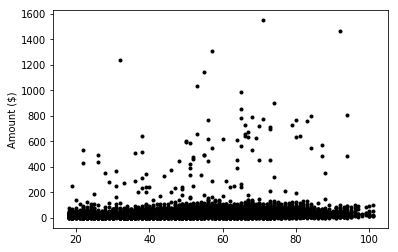

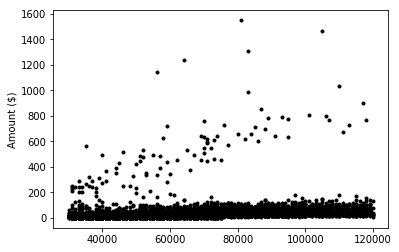

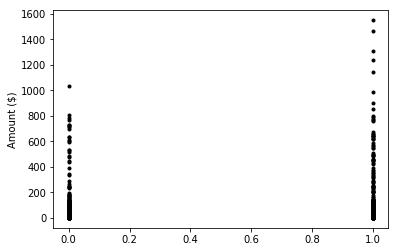

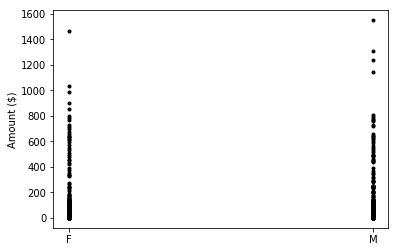

In [95]:
y = dicount_offer_comp_df_clean['total_amount']
X = dicount_offer_comp_df_clean[['age', 'income', 'member','gender']]

import pickle
from ipywidgets import widgets
import matplotlib.pyplot as plt

features_dict = X.columns
def amount_plot(X, y):
    for column in X.columns:
        valid_rows = X[column].notna()
        plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k')
        plt.ylabel('Amount ($)') 
        plt.show()

amount_plot(X, y)

In [96]:
categorical_columns = ['gender', 'member']
numeric_columns = ['age', 'income']

## Linear regression 

In [97]:
X = pd.get_dummies(data=X, drop_first=True)
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lr = LinearRegression()  # make an instance of the model 
lr.fit(train_features, train_labels)             # fit the model
y_pred = lr.predict(test_features)
print("Mean absolute error:", metrics.mean_absolute_error(test_labels, y_pred))
print("Mean squared error:", metrics.mean_squared_error(test_labels, y_pred))
print("R^2:", metrics.r2_score(test_labels, y_pred))

Mean absolute error: 21.4291768345
Mean squared error: 2423.0175915
R^2: 0.0575677955637


## Random Forest

In [99]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [100]:
y_pred = rf.predict(test_features)
print("Mean absolute error:", metrics.mean_absolute_error(test_labels, y_pred))
print("Mean squared error:", metrics.mean_squared_error(test_labels, y_pred))
print("R^2:", metrics.r2_score(test_labels, y_pred))

Mean absolute error: 26.0633238108
Mean squared error: 3449.00290859
R^2: -0.34148898698


## Lasso regression

In [101]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
lasso.fit(train_features, train_labels)
y_pred = lasso.predict(test_features)
print("Mean absolute error:", metrics.mean_absolute_error(test_labels, y_pred))
print("Mean squared error:", metrics.mean_squared_error(test_labels, y_pred))
print("R^2:", metrics.r2_score(test_labels, y_pred))

Mean absolute error: 21.4616729563
Mean squared error: 2423.46675897
R^2: 0.0573930919671


## Data Preprocessing for bogo offers

In [102]:
bogo_offer_comp_df_clean = bogo_offer_comp_df_clean.groupby('person')['amount'].sum().to_frame('total_amount').reset_index()
bogo_offer_comp_df_clean  = bogo_offer_comp_df_clean.merge(profile, left_on = 'person', right_on = 'id')

In [103]:
bogo_offer_comp_df_clean.head()

,person,total_amount,age,became_member_on,gender,id,income
0,0009655768c64bdeb2e877511632db8f,8.57,33,20170421,M,0009655768c64bdeb2e877511632db8f,72000.0
1,0011e0d4e6b944f998e987f904e8c1e5,22.05,40,20180109,O,0011e0d4e6b944f998e987f904e8c1e5,57000.0
2,0020c2b971eb4e9188eac86d93036a77,17.24,59,20160304,F,0020c2b971eb4e9188eac86d93036a77,90000.0
3,0020ccbbb6d84e358d3414a3ff76cffd,24.85,24,20161111,F,0020ccbbb6d84e358d3414a3ff76cffd,60000.0
4,004b041fbfe44859945daa2c7f79ee64,27.92,55,20180508,F,004b041fbfe44859945daa2c7f79ee64,74000.0


In [104]:
bogo_offer_comp_df_clean.describe()

,total_amount,age,became_member_on,income
count,9263.000000,9263.000000,9.263000e+03,8914.000000
mean,35.506146,58.194645,2.016548e+07,69478.236482
std,58.776162,20.278684,1.120008e+04,21634.553037
min,5.010000,18.000000,2.013073e+07,30000.000000
25%,13.990000,46.000000,2.016040e+07,53000.000000
50%,25.080000,57.000000,2.017032e+07,69000.000000
75%,43.075000,69.000000,2.017111e+07,85000.000000
max,1160.730000,118.000000,2.018073e+07,120000.000000


In [105]:
bogo_offer_comp_df_clean['member']  = bogo_offer_comp_df_clean['became_member_on'].apply(lambda x: 1 if x>2.016510e+07 else 0)
# New member is 1, old memeber is 0
bogo_offer_comp_df_clean.dropna(how='all', inplace=True)
bogo_offer_comp_df_clean = dicount_offer_comp_df_clean.loc[(dicount_offer_comp_df_clean['gender'] == 'M') | (dicount_offer_comp_df_clean['gender'] == 'F')]

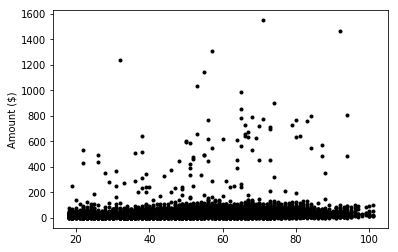

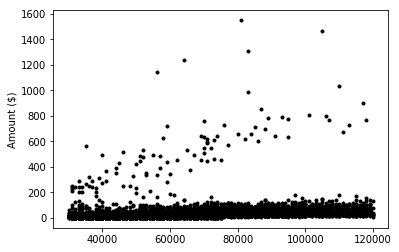

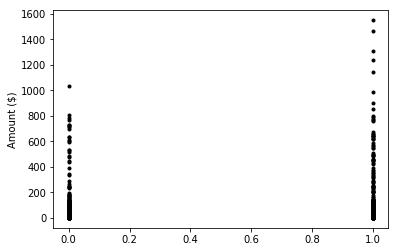

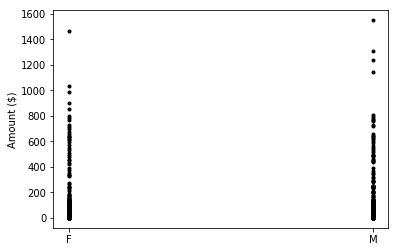

In [106]:
y = dicount_offer_comp_df_clean['total_amount']
X = dicount_offer_comp_df_clean[['age', 'income', 'member','gender']]

import pickle
from ipywidgets import widgets
import matplotlib.pyplot as plt

features_dict = X.columns
def amount_plot(X, y):
    for column in X.columns:
        valid_rows = X[column].notna()
        plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k')
        plt.ylabel('Amount ($)') 
        plt.show()

amount_plot(X, y)

In [107]:
X = from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);pd.get_dummies(data=X, drop_first=True)
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Linear regression 

In [108]:
lr = LinearRegression()  # make an instance of the model 
lr.fit(train_features, train_labels)             # fit the model
y_pred = lr.predict(test_features)
print("Mean absolute error:", metrics.mean_absolute_error(test_labels, y_pred))
print("Mean squared error:", metrics.mean_squared_error(test_labels, y_pred))
print("R^2:", metrics.r2_score(test_labels, y_pred))

Mean absolute error: 22.211972778
Mean squared error: 3377.76253804
R^2: 0.0471921911633


## Random Forest

In [110]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);
y_pred = rf.predict(test_features)
print("Mean absolute error:", metrics.mean_absolute_error(test_labels, y_pred))
print("Mean squared error:", metrics.mean_squared_error(test_labels, y_pred))
print("R^2:", metrics.r2_score(test_labels, y_pred))

Mean absolute error: 27.0107071154
Mean squared error: 4490.72880227
R^2: -0.266756150553


## Lasso regression

In [112]:
lasso = Lasso(alpha=1.0)
lasso.fit(train_features, train_labels)
y_pred = lasso.predict(test_features)
print("Mean absolute error:", metrics.mean_absolute_error(test_labels, y_pred))
print("Mean squared error:", metrics.mean_squared_error(test_labels, y_pred))
print("R^2:", metrics.r2_score(test_labels, y_pred))

Mean absolute error: 22.239654984
Mean squared error: 3379.6648125
R^2: 0.0466555927663
